In [1]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [3]:
# Get project files
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

--2024-02-25 12:23:56--  https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.2.33, 172.67.70.149, 104.26.3.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.2.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70702765 (67M) [application/zip]
Saving to: ‘cats_and_dogs.zip.1’

cats_and_dogs.zip.1 100%[===================>]  67.43M  82.4MB/s    in 0.8s    

2024-02-25 12:23:57 (82.4 MB/s) - ‘cats_and_dogs.zip.1’ saved [70702765/70702765]

Archive:  cats_and_dogs.zip
replace cats_and_dogs/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [23]:
# 3
train_image_generator = ImageDataGenerator(rescale = 1.0/255)
validation_image_generator = ImageDataGenerator(rescale = 1.0/255)
test_image_generator = ImageDataGenerator(rescale = 1.0/255)

train_data_gen = train_image_generator.flow_from_directory(
        train_dir,
        target_size=(IMG_HEIGHT,IMG_WIDTH),
        batch_size=batch_size,
        class_mode='binary')

val_data_gen = validation_image_generator.flow_from_directory(
        validation_dir,
        target_size=(IMG_HEIGHT,IMG_WIDTH),
        batch_size=batch_size,
        class_mode='binary')

test_data_gen = test_image_generator.flow_from_directory(
        PATH,
        target_size=(IMG_HEIGHT,IMG_WIDTH),
        batch_size=batch_size,
        shuffle=False,
        classes=['test'])

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


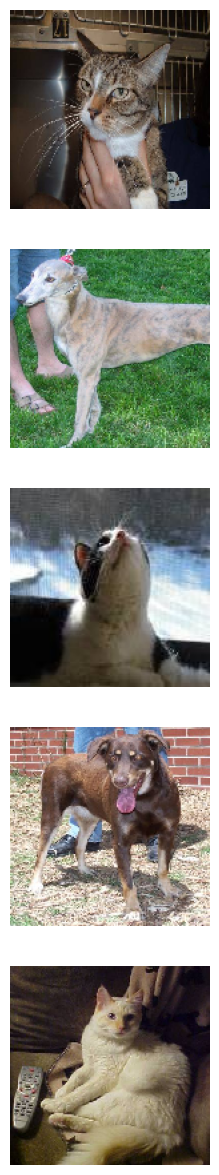

In [29]:
# 4
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])


In [30]:
# 5
'''
Creating more training data from existing training examples by using random transformations
in order to prevent overfitting from using a small training dataset.
Add 4-6 random transformations as arguments to ImageDataGenerator.
Make sure to rescale the same as before.
'''

train_image_generator = ImageDataGenerator(rescale = 1.0/255,
                                           featurewise_center=True,
                                           featurewise_std_normalization=True,
                                           horizontal_flip=True,
                                           rotation_range=20,
                                           width_shift_range=0.2,
                                           height_shift_range=0.2,
                                           )


Found 2000 images belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1862: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1872: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


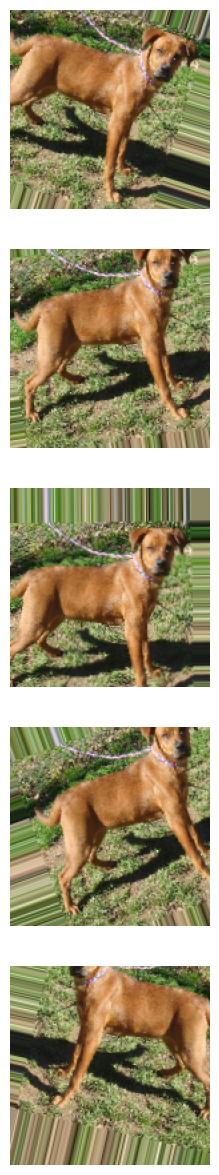

In [31]:
# 6
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

In [33]:
train_data_gen[0][0][0].shape

/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1862: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1872: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


(150, 150, 3)

In [67]:
# 7
'''
Create the neural network that outputs the class probability
Conv2D and MaxPooling2D layers and then a fully connected layer on top that is activated by a ReLU activation function
'''

model = Sequential()

# Concolutional base
model.add(Conv2D(32,(3,3), activation='relu', input_shape=(IMG_HEIGHT,IMG_WIDTH,3)))
model.add(MaxPooling2D((2,2)))  # to reduce dimensionalities
model.add(Conv2D(64,(3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(32,(3,3), activation='relu'))

# Take the extracted features and add classifying layer
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])




Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 74, 74, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_15 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 36, 36, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 34, 34, 32)        18464     
                                                                 
 flatten_7 (Flatten)         (None, 36992)            

In [68]:
# 8
history = model.fit(train_data_gen,
                    steps_per_epoch=10,
                    epochs = epochs,
                    validation_data = val_data_gen,
                    validation_steps=6)

/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1862: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1872: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


Epoch 1/15
10/10 [==============================] - 73s 7s/step - loss: 0.8328 - accuracy: 0.5063 - val_loss: 0.6928 - val_accuracy: 0.5247
Epoch 2/15
10/10 [==============================] - 64s 6s/step - loss: 0.6924 - accuracy: 0.5252 - val_loss: 0.6933 - val_accuracy: 0.5065
Epoch 3/15
10/10 [==============================] - 67s 7s/step - loss: 0.6927 - accuracy: 0.5344 - val_loss: 0.6944 - val_accuracy: 0.5013
Epoch 4/15
10/10 [==============================] - 67s 7s/step - loss: 0.6899 - accuracy: 0.5047 - val_loss: 0.6847 - val_accuracy: 0.5000
Epoch 5/15
10/10 [==============================] - 67s 7s/step - loss: 0.6861 - accuracy: 0.5180 - val_loss: 0.6687 - val_accuracy: 0.5182
Epoch 6/15
10/10 [==============================] - 67s 7s/step - loss: 0.6830 - accuracy: 0.5477 - val_loss: 0.6714 - val_accuracy: 0.5990
Epoch 7/15
10/10 [==============================] - 65s 7s/step - loss: 0.6698 - accuracy: 0.5787 - val_loss: 0.6771 - val_accuracy: 0.5573
Epoch 8/15
10/10 [==

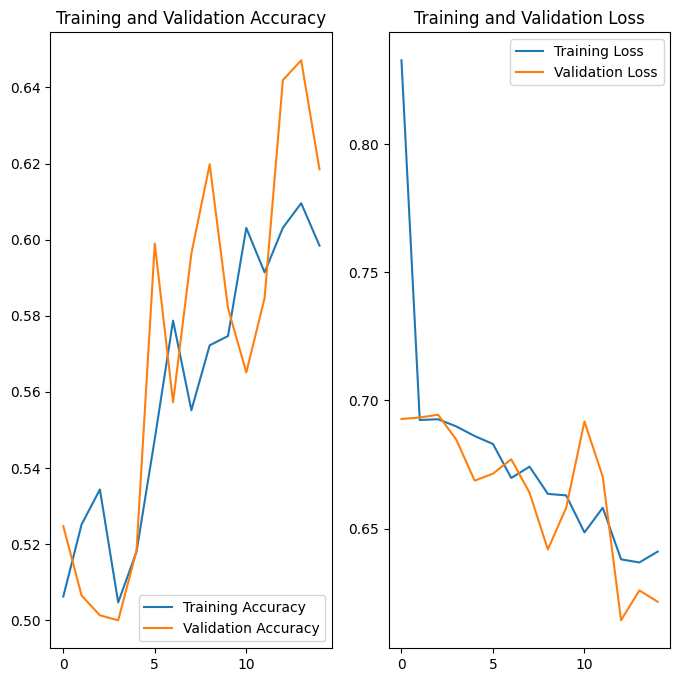

In [69]:
# 9
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [70]:
# 10
''' prediction using test_data_gen
probabilities should be a list of integer
'''

prediction = model.predict(test_data_gen)
probabilities = []
for i in range(len(prediction)):
  probabilities.append(prediction.tolist()[i][0])
probabilities

1/1 [==============================] - 1s 650ms/step


[0.5593712329864502,
 0.4772616922855377,
 0.2135176956653595,
 0.3902800679206848,
 0.47939446568489075,
 0.4890556037425995,
 0.4787371754646301,
 0.47335052490234375,
 0.5576900243759155,
 0.8509416580200195,
 0.42117196321487427,
 0.5285972952842712,
 0.34931138157844543,
 0.5477493405342102,
 0.46855485439300537,
 0.5744079947471619,
 0.39243894815444946,
 0.6486716270446777,
 0.40920156240463257,
 0.5065469741821289,
 0.3140668272972107,
 0.4272410273551941,
 0.3764306306838989,
 0.5460265278816223,
 0.6058133244514465,
 0.5023636221885681,
 0.7057929039001465,
 0.492698073387146,
 0.5014225840568542,
 0.5706106424331665,
 0.6277506351470947,
 0.4399809241294861,
 0.5340571403503418,
 0.9982997179031372,
 0.44471725821495056,
 0.584539532661438,
 0.9910001754760742,
 0.5000370740890503,
 0.4482320547103882,
 0.45975640416145325,
 0.5487594604492188,
 0.4805382192134857,
 0.7216065526008606,
 0.3808548152446747,
 0.2671207785606384,
 0.40252208709716797,
 0.4593565762042999,
 0.37

In [64]:
test_images, _ = next(test_data_gen)
plotImages(test_images, probabilities=prediction)

Output hidden; open in https://colab.research.google.com to view.

In [71]:
# 11
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

Your model correctly identified 78.0% of the images of cats and dogs.
You passed the challenge!
